# RNNs: IMDb Example

## Word Embeddings
The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of such a noisy, unstructured embedding space.

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points far away from each other, while related words would be closer). Even beyond mere distance, we may want specific directions in the embedding space to be meaningful.

It is thus reasonable to learn a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it even easier. It's just about learning the weights of a layer: the `Embedding` layer.

The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, it looks up these integers in an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape (`samples`, `sequence_length`), where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). **All sequences in a batch must have the same length**, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape (`samples`, `sequence_length`, `embedding_dimensionality`). Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer (which we'll cover in a later lecture).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for.

### IMDb Example
Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.

In [0]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os

# Import the TF V2 through this magic command
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

# Check the Version of the Tensor Flow. It should be the version 2
print(tf.__version__)
import keras
from keras.datasets import imdb
from keras import preprocessing

2.2.0-rc3


Using TensorFlow backend.


In [0]:
# Number of words to consider as features
max_features = 10000

# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers into a 2D integer tensor 
# of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 2s 0us/step


In [0]:
model = tf.keras.models.Sequential([
  # We specify the maximum input length to our Embedding layer
  # so we can later flatten the embedded inputs
  tf.keras.layers.Embedding(10000, 8, input_length = maxlen),
  
  # After the Embedding layer, 
  # our activations have shape (samples, maxlen, 8).

  # We flatten the 3D tensor of embeddings 
  # into a 2D tensor of shape (samples, maxlen * 8)
  tf.keras.layers.Flatten(),

  # We add the classifier on top
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics = ['accuracy'])


history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_split = 0.2)

Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6609 - accuracy: 0.6412 - val_loss: 0.6035 - val_accuracy: 0.7084
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5300 - accuracy: 0.7546 - val_loss: 0.5208 - val_accuracy: 0.7334
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4563 - accuracy: 0.7903 - val_loss: 0.4987 - val_accuracy: 0.7470
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4194 - accuracy: 0.8100 - val_loss: 0.4927 - val_accuracy: 0.7546
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3932 - accuracy: 0.8245 - val_loss: 0.4944 - val_accuracy: 0.7572
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3719 - accuracy: 0.8370 - val_loss: 0.4962 - val_accuracy: 0.7594
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3518 - accuracy: 0.8458 - val_loss: 0.5014 - val_accuracy: 0.7614
Epoch 

We get to a validation accuracy of ~75%, which is pretty good considering that we only look at the first 20 words in every review. But note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both "this movie is shit" and "this movie is the shit" as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on next.

## Using pre-trained word embeddings
Sometimes, you have so little training data available that you could never use your data alone to learn an appropriate task-specific embedding of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec embeddings or any other word embedding database that you can download. 

### From raw text to word embeddings
We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a Dense layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in Keras, we will start from scratch, by downloading the original text data.

Download the IMDB data as raw text
First, head to [here](http://ai.stanford.edu/~amaas/data/sentiment/) and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels (positive / negative) into a labels list:

In [0]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive. 
# Go to the link and copy the authorization code

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
imdb_dir = 'drive/My Drive/Teaching/BST 261/2020/In progress notebooks/imdb_rnns'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data

Let's vectorize the texts we collected, and prepare a training and validation split.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 samples. So we will be learning to classify movie reviews after looking at just 200 examples.

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100                # We will cut reviews after 100 words
training_samples = 200      # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000           # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25030, 100)
Shape of label tensor: (25030,)


### Download the GloVe word embeddings

Head [here](https://nlp.stanford.edu/projects/glove/) (where you can learn more about the GloVe algorithm), and download the pre-computed embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings

Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number vectors).

In [0]:
glove_dir = 'drive/My Drive/Teaching/BST 261/2020/In progress notebooks/glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index (built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [0]:
model = tf.keras.models.Sequential([
  # We specify the maximum input length to our Embedding layer
  # so we can later flatten the embedded inputs
  tf.keras.layers.Embedding(max_words, embedding_dim, input_length = maxlen),

  tf.keras.layers.Flatten(),

  # We add the classifier on top
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model

The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already learned features.

### Train and evaluate

Let's compile our model and train it:

In [0]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 106ms/step - loss: 1.4063 - accuracy: 0.4950 - val_loss: 1.1212 - val_accuracy: 0.4991
Epoch 2/10
7/7 [==============================] - 1s 81ms/step - loss: 0.9577 - accuracy: 0.5650 - val_loss: 0.7946 - val_accuracy: 0.4993
Epoch 3/10
7/7 [==============================] - 1s 86ms/step - loss: 0.3863 - accuracy: 0.8300 - val_loss: 1.5403 - val_accuracy: 0.4993
Epoch 4/10
7/7 [==============================] - 1s 82ms/step - loss: 0.3872 - accuracy: 0.8250 - val_loss: 0.8061 - val_accuracy: 0.5378
Epoch 5/10
7/7 [==============================] - 1s 82ms/step - loss: 0.1278 - accuracy: 0.9800 - val_loss: 1.1532 - val_accuracy: 0.5046
Epoch 6/10
7/7 [==============================] - 1s 83ms/step - loss: 0.3122 - accuracy: 0.8550 - val_loss: 0.7104 - val_accuracy: 0.5812
Epoch 7/10
7/7 [==============================] - 1s 82ms/step - loss: 0.0544 - accuracy: 1.0000 - val_loss: 0.7359 - val_accuracy: 0.5812
Epoch 8/10
7/7 [==========

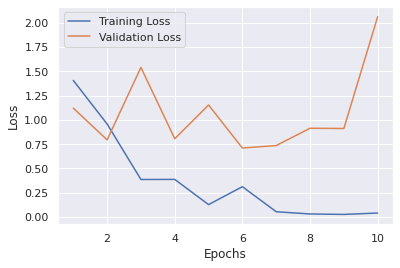

In [0]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

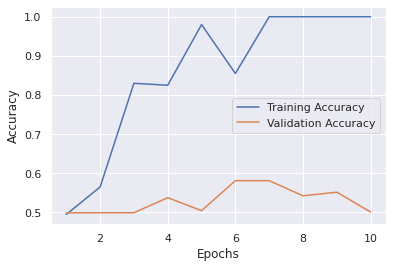

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [0]:
model2 = tf.keras.models.Sequential([
  # We specify the maximum input length to our Embedding layer
  # so we can later flatten the embedded inputs
  tf.keras.layers.Embedding(max_words, embedding_dim, input_length = maxlen),

  tf.keras.layers.Flatten(),

  # We add the classifier on top
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer = tf.keras.optimizers.RMSprop(),
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

history2 = model2.fit(x_train, y_train,
                      epochs=10,
                      batch_size=32,
                      validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 96ms/step - loss: 0.6950 - accuracy: 0.4800 - val_loss: 0.6977 - val_accuracy: 0.5081
Epoch 2/10
7/7 [==============================] - 1s 89ms/step - loss: 0.4979 - accuracy: 0.9750 - val_loss: 0.6965 - val_accuracy: 0.5097
Epoch 3/10
7/7 [==============================] - 1s 88ms/step - loss: 0.2771 - accuracy: 1.0000 - val_loss: 0.6989 - val_accuracy: 0.5270
Epoch 4/10
7/7 [==============================] - 1s 88ms/step - loss: 0.1178 - accuracy: 1.0000 - val_loss: 0.6976 - val_accuracy: 0.5298
Epoch 5/10
7/7 [==============================] - 1s 86ms/step - loss: 0.0551 - accuracy: 1.0000 - val_loss: 0.7171 - val_accuracy: 0.5257
Epoch 6/10
7/7 [==============================] - 1s 86ms/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.7108 - val_accuracy: 0.5309
Epoch 7/10
7/7 [==============================] - 1s 90ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.7135 - val_accuracy: 0.5275
Epoch 8/10
7/7 [===========

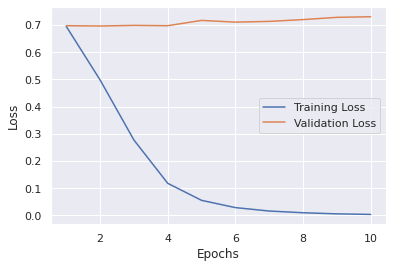

In [0]:
import seaborn as sns
sns.set()

train_acc  = history2.history['accuracy']
train_loss = history2.history['loss']
val_acc  = history2.history['val_accuracy']
val_loss = history2.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

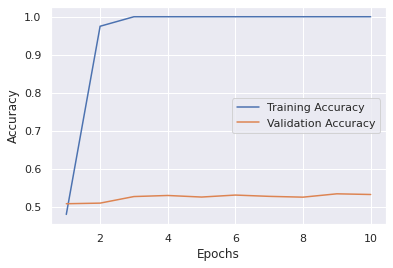

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [0]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [0]:
#model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 37us/step


[0.7772021975708008, 0.5656]

We get an appalling test accuracy of 56%. Working with just a handful of training samples is hard!


## Building a simple RNN

We'll first use the `SimpleRNN` layer. Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor argument. Let's take a look at an example:

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(10000, 32),

  tf.keras.layers.SimpleRNN(32),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(10000, 32),

  tf.keras.layers.SimpleRNN(32, return_sequences=True),
])

It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all intermediate layers to return full sequences:

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(10000, 32),

  tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.SimpleRNN(32), # This last layer only returns the last outputs.
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try this on the IMDb data.

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500          # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(max_features, 32),

  tf.keras.layers.SimpleRNN(32),

  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 24s 152ms/step - loss: 0.5717 - accuracy: 0.6953 - val_loss: 0.4998 - val_accuracy: 0.7640
Epoch 2/10
157/157 [==============================] - 23s 145ms/step - loss: 0.3500 - accuracy: 0.8584 - val_loss: 0.3309 - val_accuracy: 0.8650
Epoch 3/10
157/157 [==============================] - 23s 145ms/step - loss: 0.2672 - accuracy: 0.8941 - val_loss: 0.4153 - val_accuracy: 0.8022
Epoch 4/10
157/157 [==============================] - 23s 146ms/step - loss: 0.2083 - accuracy: 0.9226 - val_loss: 0.4286 - val_accuracy: 0.8112
Epoch 5/10
157/157 [==============================] - 23s 146ms/step - loss: 0.1723 - accuracy: 0.9376 - val_loss: 0.4200 - val_accuracy: 0.8508
Epoch 6/10
157/157 [==============================] - 23s 147ms/step - loss: 0.1324 - accuracy: 0.9518 - val_loss: 0.4330 - val_accuracy: 0.8604
Epoch 7/10
157/157 [==============================] - 23s 146ms/step - loss: 0.0969 - accuracy: 0.9675 - val_loss: 0.4522 - val_ac

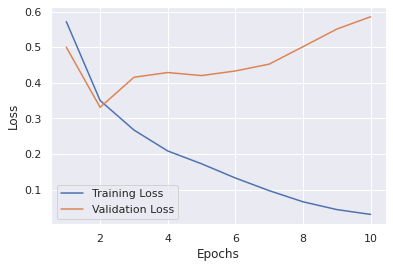

In [0]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

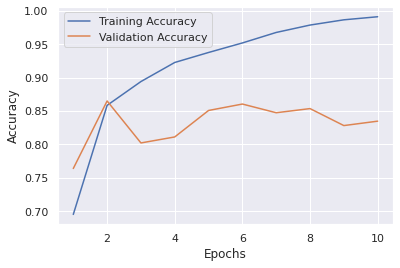

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

As a reminder, in lecture 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is that our inputs only consider the first 500 words rather the full sequences -- hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. We'll talk about these in the next lectures.